Submitted by: Rehnuma Shabnam Ananya, Nasim Uddin Ahmed

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

# Creating Adversarial Examples

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
#preprocessing
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [4]:
#model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [5]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0198 - accuracy: 0.8636 - val_loss: 0.0064 - val_accuracy: 0.9572
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0094 - accuracy: 0.9388 - val_loss: 0.0059 - val_accuracy: 0.9618
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0077 - accuracy: 0.9506 - val_loss: 0.0049 - val_accuracy: 0.9666
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0068 - accuracy: 0.9561 - val_loss: 0.0040 - val_accuracy: 0.9738
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0061 - accuracy: 0.9607 - val_loss: 0.0038 - val_accuracy: 0.9755
Epoch 6/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0056 - accuracy: 0.9647 - val_loss: 0.0038 - val_accuracy: 0.9746
Epoch 7/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0052 - accuracy: 0.9669 - val_loss: 0.0039 - val_ac

In [9]:
print("regular images acuracy:", model.evaluate(x=x_test, y=y_test, verbose=0))

regular images acuracy: [0.0030532467644661665, 0.9814000129699707]


In [7]:
#perturbation
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad


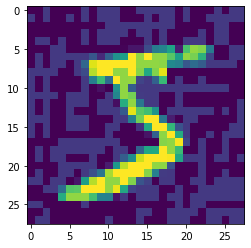

five
three


In [8]:
#creating adversarial example
image = x_train[0]
image_label = y_train[0]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

# Adversarial Training

In [11]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [16]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))

In [17]:
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.0013 - accuracy: 0.9928 - val_loss: 0.0174 - val_accuracy: 0.9072
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 5.1690e-05 - accuracy: 0.9998 - val_loss: 0.0138 - val_accuracy: 0.9265
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 4.9987e-05 - accuracy: 0.9998 - val_loss: 0.0151 - val_accuracy: 0.9199
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 1.0832e-04 - accuracy: 0.9993 - val_loss: 0.0116 - val_accuracy: 0.9377
Epoch 5/10
625/625 [==============================] - 5s 7ms/step - loss: 1.0030e-05 - accuracy: 0.9999 - val_loss: 0.0132 - val_accuracy: 0.9289
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 7.2271e-05 - accuracy: 0.9995 - val_loss: 0.0122 - val_accuracy: 0.9340
Epoch 7/10
625/625 [==============================] - 5s 7ms/step - loss: 8.9723e-05 - accuracy: 0.9995 - val_loss: 0.0170 - val

In [18]:
print("Defended accuracy adviseral:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

print("Defended accuracy regular:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy adviseral: [2.930564683968247e-19, 1.0]
Defended accuracy regular: [0.013184918090701103, 0.9294000267982483]
